# Decision Tree for N-dimensional data and labels
The code below implements a decision tree calculated on all the data, for one label depending on several independent variables.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import log, e
import random
import sys

### Custom Libraries

In [2]:
import density_tree as dt

The methods implemented for producing a decision tree can be found in the python files under the package `density_tree`.


# Unsupervised entropy with unlabelled clusters
Below are some functions that compute an optimal split for unlabelled data, using the differential entropy of a d-variate Gaussian density. 

First, let's generate some unlabelled data:


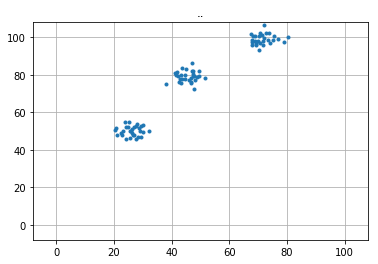

In [3]:
dimensions = 2
nclusters = 3
covariance =  10
npoints = 30
minRange = 0
maxRange = 100

dataset, clusters = dt.create_data.createData(nclusters, dimensions, covariance, npoints)
dataset=dataset[:,:-1]
dt.plots.plotData(dataset,title="..", labels = False,
                 minRange = minRange, maxRange = maxRange)

In [4]:
# %load ./density_tree/density_tree.py
# %%writefile ./density_tree/density_tree.py
import numpy as np

def entropy_gaussian(S, base=2):
    """
    Differential entropy of a d-variate Gaussian density
    :param S: dataset in R^(N*D)
    :param base: base of entropy
    :return: entropy
    """
    K = np.linalg.det(np.cov(S.T))
    d = np.shape(S)[1]
    
    entropy = np.multiply(np.power(2 * np.pi * np.exp(1), d), K)
    if entropy <= 0:
        return 0
    entropy = np.log(entropy) / (np.log(base) * 2)
    if np.isnan(entropy):
        entropy = 0
    return entropy


def get_ig_dim(dataset, dim, entropy_f = entropy_gaussian, base = 2):
    """for one dimension, get information gain"""
    ig_vals = []
    split_vals = []

    # loop over all possible cut values
    for split_val in np.linspace(dataset[2, dim],dataset[-2, dim],100):  # TODO remove 1:-2, find out why beginning and end cause crash
        # split values
        split_rand_l = dataset[dataset[:, dim] < split_val]
        split_rand_r = dataset[dataset[:, dim] >= split_val]
        
        # entropy
        entropy_l = entropy_f(split_rand_l, base=base)
        entropy_r = entropy_f(split_rand_r, base=base)
        entropy_tot = entropy_f(dataset, base=base)

        # information gain
        ig = entropy_tot - (entropy_l * len(split_rand_l) /
                            len(dataset) + entropy_r * len(split_rand_r) / len(dataset))
        # append split value and information gain
        split_vals.append(split_val)
        ig_vals.append(ig)

    return np.array(ig_vals), np.array(split_vals)

def get_best_split(dataset):
    """for a given dimension, get best split based on information gain"""

    # get all information gains on all dimensions
    ig_dims_vals, split_dims_vals = [], []
    for dim in range(np.shape(dataset)[1]): # loop all dimensions
        ig_vals, split_vals = get_ig_dim(dataset, dim)
        ig_dims_vals.append(ig_vals)
        split_dims_vals.append(split_vals)

    # select best information gain and dimension
    # TODO implement

    return ig_dims_vals, split_dims_vals


test set for differential Gaussian entropy function

In [5]:
np.seterr(all='print')
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    ig_dims_vals, split_dims_vals = get_best_split(dataset)

Show information gain per cut on axis

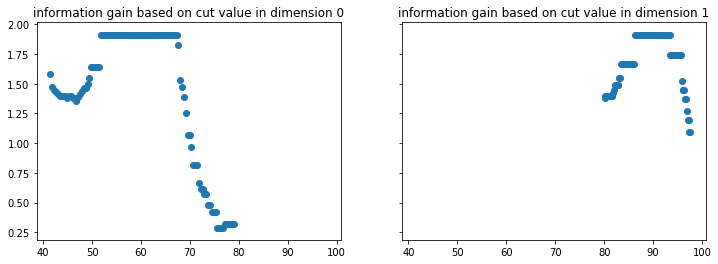

In [6]:
f, axes = plt.subplots(1,2, sharex=True, sharey=True)
f.set_size_inches((12,4))
for dim in [0,1]:
    axes[dim].scatter(split_dims_vals[dim],ig_dims_vals[dim])
    axes[dim].set_title("information gain based on cut value in dimension "+str(dim))
plt.show()

In [7]:
def get_best_split():
    # dimension of maximum gain
    dim_max = np.argmax(np.max(ig_dims_vals,axis=1))
    
    # maximum gain split value
    middle_max_ind = np.where(np.equal(ig_dims_vals[dim_max],np.max(ig_dims_vals[dim_max]))) # take the middle if there are several maximum values
    middle_max_ind = int(np.floor(np.mean(middle_max_ind)))
    val_dim_max = split_dims_vals[dim_max][middle_max_ind]
    return dim_max, val_dim_max

dim_max, val_dim_max = get_best_split()
get_best_split()

(0, 59.312159983595421)

For tree descent, we have to decide how many clusters we want to produce (limit depth) or what should be the threshold of information gain for the algorithm to stop (information gain limit)

In [8]:
def next_split(left, right, results, root):
    """
    recursive method to split variables on dimension until all variables are contained in one subspace. G
    1. Get left (l) and right (r) based on split
    2. Check if labels unique
    3. Get entropies for all split values in ll rr
    4. Recurse -> 1.
    """
    for side in (left, right):  # loop both sides
        dt_node = Node() # decision tree node]
        dt_node.parent = root
        # <<< dt_node.labels = np.unique(np.asarray(side)[:, -1])  # get variables (in last column)
        
        if np.array_equal(left, side):
            dt_node.parent.left = dt_node
        elif np.array_equal(right, side):
            dt_node.parent.right = dt_node
        
        #if len(dt_node.labels) > 1:  # if there are still more than one labels in a side
            side = np.asarray(side)
            dfs = calc_entropy_attribute(side)  # get entropies for all attributes within side
            min_df = get_best_attr(dfs)  # get best split value
            # dataframe
            results.append(create_df_results(min_df))
            
            dt_node.split_value = min_df["cut value"].values[0]
            dt_node.split_dimension = min_df["dimension"].values[0]
            left_new, right_new = split(side, 
                                        dt_node.split_dimension,
                                        dt_node.split_value) # get new left and right labels
            
            # save results for dataframe
            next_split(left_new, right_new, results, dt_node)  # split, recursion
            
def create_df_results(node):
    df = pd.DataFrame(node.split_dimension,node,split_value)
    df.reset_index()
    return df

def create_decision_tree(dimensions = 0, subsample = 0):
    """create decision tree be performing initial split,
    then recursively splitting until all labels are in unique bins
    """
    # TODO modify such as to take as entry number of variables to create tree on, number of data subsamples etc.
    
    root = Node() # initial node
    # initial split
    # <<< dfs = calc_entropy_attribute(dataset)
    # <<< min_df = get_best_attr(dfs)
    dim_max, val_dim_max = get_best_split() 
    
    root.split_dimension = dim_max # <<< min_df["dimension"].values[0]
    root.split_value = val_dim_max # <<<< min_df["cut value"].values[0]
    # <<< root.labels = np.unique(dataset[:,-1])
    
    left,right=split(dataset, 
                 root.split_dimension, # dimension of min cut value
                 root.split_value) # min cut value
    results=[create_df_results(root)]
    # recursively continue splitting
    next_split(left, right, results, root) # iterate
    return results, root


# Labelled data

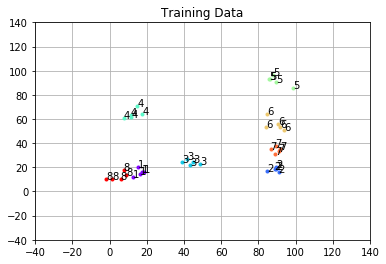

In [9]:
# cluster parameters
nclusters=8
dimensions=2
covariance=10
minRange=0
maxRange=100
npoints=5

    
dataset, clusters = dt.create_data.createData(nclusters, dimensions, covariance, npoints,)
dt.plots.plotData(clusters, title="Training Data", clusters=clusters,
                  minRange = minRange, maxRange = maxRange, covariance=covariance)

### Calculate the entropy over all possible split values in all dimensions (`calc_entropy attribute`)


Now we can iterate the same procedure over the both splitted sides until there is no split left.

In [10]:
#%%writefile ./density_tree/decision_tree_traverse.py
# Binary tree node to save binary tree nodes

class Node:
    """
    constructor for new nodes
    # decision rule is the rule which splits labels in two groups labels_left and labels_right
    # left_rule and right_rule are pointers to the rules that have to be used
    # to further split labels_left and labels_right
    """

    def __init__(self):
        # data for node
        self.parent = None  # parent node
        self.labels = None  # the labels contained at this split level
        self.split_value = None  # the split value
        self.split_dimension = None  # the split dimension

        # child nodes
        self.left = None  # node to the left, e.g., for value < split_value
        self.left_labels = None
        self.right = None
        self.right_labels = None

    """print data for node"""

    def has_children(self):
        if (self.right != None) & (self.right != None):
            return True
        return False

    def __format__(self):
        # print("rule: " + self.decisionrule) # print a decision rule on one line as a string (e.g., `d(2) < 20`)
        print("labels: " + str(self.labels))
        if self.has_children():
            print("split dimension: " + str(self.split_dimension))
            print("split value: " + str(self.split_value))

    """get tree depth"""
    def depth(self):
        left_depth = self.left.depth() if self.left else 0
        right_depth = self.right.depth() if self.right else 0
        return max(left_depth, right_depth) + 1

    """traversal methods"""
    def traverse_inorder(self):
        if self.left is not None:
            self.left.traverse_inorder()
        self.__format__()
        if self.right is not None:
            self.right.traverse_inorder

    def traverse_preorder(self):
        self.__format__()
        if self.left is not None:
            self.left.traverse_preorder()
        if self.right is not None:
            self.right.traverse_preorder()

    def traverse_postorder(self):
        if self.left is not None:
            self.left.traverse_preorder()
        if self.right is not None:
            self.right.traverse_preorder()
        self.__format__()
        raise NotImplementedError
        


In [11]:
#%%writefile ./density_tree/decision_tree_create.py
"""Functions for entropy and splitting"""

import numpy as np
import pandas as pd


def split(dataset, index, split_value):  # [2]
    """
    split a dataset (columns: variables, rows: data) in two according to some column (index) value.
    :param dataset: input dataset
    :param index: index of dimension to split values on
    :param split_value: value of the dimension where the dataset is split
    :return: left and right split datasets
    """
    left, right = list(), list()
    for row in dataset:
        if row[index] < split_value:
            left.append(row)
        else:
            right.append(row)
    return left, right


def entropy(labels, base=np.e):  # [1]
    """
    Calculate the entropy for a set of labels.
    :param labels: an array of labels
    :param base: base of entropy, by default e
    :return: entropy
    """
    value, counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    return -(norm_counts * np.log(norm_counts) / np.log(base)).sum()

def entropy_discrete(dataset, dim):
    """
    calculate the entropy values for all cuts on one attribute (left<cut, right>=cut).
    :param dataset: Input array with data and label in rows. The last column contains the labels.
    :param dim: The index of the column for which the entropy should be computed.
    :return: entropy values, corresponding split values
    """
    x_vals, entropy_vals = list(), list()
    uniquevals = (np.unique(dataset[:, dim]))
    left_labels_unique, right_labels_unique = list(), list()
    
    # loop all possible split values
    for split_x in uniquevals[1:]:
        # append value
        x_vals.append(split_x)

        # split on value
        left, right = split(dataset, dim, split_x)
        left = np.asarray(left)
        right = np.asarray(right)

        # labels
        left_labels = left[:, -1]  # last column = labels
        right_labels = right[:, -1]

        # unique labels
        left_labels_unique.append(np.unique(left_labels))
        right_labels_unique.append(np.unique(right_labels))

        # entropy for split
        left_entropy = entropy(left_labels, base=2)
        right_entropy = entropy(right_labels, base=2)

        # total entropy for attribute
        # TODO change to information gain
        entropy_attr_split = left_entropy * len(left) / len(dataset) + right_entropy * len(right) / len(dataset)
        entropy_vals.append(entropy_attr_split)

    return entropy_vals, x_vals, left_labels_unique, right_labels_unique


def data_to_clusters(dataset):
    """Helper function to get clusters from estimated labels"""
    clusters = []
    for val in np.unique(dataset[:, 2]):
        clusters.append(dataset[dataset[:, 2] == val])
    return clusters


def get_unique_labels(labels):
    ul_side, ul_side_c = [], []

    for i in labels:
        ul_side_c.append(len(np.unique(i)))  # count of unique values on right side
        if len(np.unique(i)) == 1:  # if there is only one label, print the label
            ul_side.append(i)
        else:  # if there are several labels, print the number of the labels
            ul_side.append(i)
            # ul_side.append('several')
    return ul_side, ul_side_c


def calc_entropy_attribute(dataset):
    '''find the lowest entropy for a given attribute'''
    dfs = []
    entropy_attr = []
    x_attr = []

    for attribute_ind in range(np.shape(dataset, )[1] - 1): # loop over all attributes

        # get the entropy for all cuts
        entropy_vals_attr, xs_vals_attr, left_l_unique, right_l_unique = entropy_discrete(dataset,attribute_ind)
        # get number of unique labels (= cluster) on both sides
        ul_l, ul_l_c = get_unique_labels(left_l_unique)
        ul_r, ul_r_c = get_unique_labels(right_l_unique)

        # append values for all splits to dataframe
        x_attr.append(xs_vals_attr)
        entropy_attr.append(np.asarray(entropy_vals_attr))
        
        df = pd.DataFrame({'cut value': x_attr[attribute_ind],
                           'entropy': list(entropy_attr[attribute_ind]),
                           'left clusters': ul_l_c,
                           'right clusters': ul_r_c,
                           'left labels': ul_l,
                           'right labels': ul_r},
                          columns=['cut value', 'entropy', 'left clusters',
                                   'right clusters', 'left labels', 'right labels'])
        df.reset_index(inplace=True)
        dfs.append(df)
        
    return dfs


def get_best_attr(dfs):
    """get the attribute cutting which the information gain is highest"""
    min_e = np.infty

    for i in range(len(dfs)):  # loop all variables
        df = dfs[i]
        min_df_attr = df.loc[df['entropy'].argmin()]
        if min_df_attr['entropy'] < min_e:
            min_e = min_df_attr['entropy']
            min_df = pd.DataFrame(min_df_attr.drop("index")).transpose()
            min_df["dimension"] = i

    return min_df  # value of lowest entropy after possible cut, cut value, dimension


def next_split(left, right, results, root):
    """
    recursive method to split variables on dimension until all variables are contained in one subspace. G
    1. Get left (l) and right (r) based on split
    2. Check if labels unique
    3. Get entropies for all split values in ll rr
    4. Recurse -> 1.
    """
    for side in (left, right):  # loop both sides
        dt_node = Node() # decision tree node]
        dt_node.parent = root
        dt_node.labels = np.unique(np.asarray(side)[:, -1])  # get variables (in last column)
        
        if np.array_equal(left, side):
            dt_node.parent.left = dt_node
        elif np.array_equal(right, side):
            dt_node.parent.right = dt_node

        
        
        if len(dt_node.labels) > 1:  # if there are still more than one labels in a side
            side = np.asarray(side)
            dfs = calc_entropy_attribute(side)  # get entropies for all attributes within side
            min_df = get_best_attr(dfs)  # get best split value
            # dataframe
            results.append(min_df)
            
            dt_node.split_value = min_df["cut value"].values[0]
            dt_node.split_dimension = min_df["dimension"].values[0]
            left_new, right_new = split(side, 
                                        dt_node.split_dimension,
                                        dt_node.split_value) # get new left and right labels
            
            # save results for dataframe
            next_split(left_new, right_new, results, dt_node)  # split, recursion
            
def create_decision_tree(dimensions = 0, subsample = 0):
    """create decision tree be performing initial split,
    then recursively splitting until all labels are in unique bins
    """
    # TODO modify such as to take as entry number of variables to create tree on, number of data subsamples etc.
    
    root = Node() # initial node
    # initial split
    dfs = calc_entropy_attribute(dataset)
    min_df = get_best_attr(dfs)
    
    root.split_value = min_df["cut value"].values[0]
    root.split_dimension = min_df["dimension"].values[0]
    root.labels = np.unique(dataset[:,-1])
    
    left,right=split(dataset, 
                 min_df["dimension"].values[0], # dimension of min cut value
                 min_df["cut value"].values[0]) # min cut value
    results=[min_df]
    # recursively continue splitting
    next_split(left, right, results, root) # iterate
    return results, root

In [12]:
results, root = create_decision_tree()
df_results=pd.concat(results)

In [13]:
root.depth()

4

,cut value,entropy,left clusters,right clusters,left labels,right labels,dimension
19,84.0656,2,4,4,"[1.0, 3.0, 4.0, 8.0]","[2.0, 5.0, 6.0, 7.0]",0
9,22.0285,1,2,2,"[1.0, 8.0]","[3.0, 4.0]",1
4,12.6005,-0,1,1,[8.0],[1.0],0
4,39.0341,-0,1,1,[4.0],[3.0],0
9,50.8763,1,2,2,"[2.0, 7.0]","[5.0, 6.0]",1
4,31.0539,-0,1,1,[2.0],[7.0],1
4,85.5744,-0,1,1,[6.0],[5.0],1


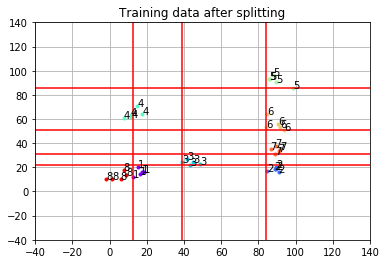

In [14]:
x_split=df_results[df_results["dimension"]==0]["cut value"].values
y_split=df_results[df_results["dimension"]==1]["cut value"].values

display(df_results)
dt.plots.plotData_tree_split(clusters, x_split, y_split, title="Training data after splitting",
                            minRange = minRange, maxRange = maxRange, covariance=covariance)

Next, we will output the decision forest to produce a $\LaTeX$ figure.

In [15]:
def print_rule(root):
    rule_string = str(root.split_dimension)+"$<$"+str(np.round(root.split_value,1))
    return rule_string
    #print(root.split_dimension,end="")

def printstuff(node,something):
    something+="["
    if len(node.labels) > 1:
        something += print_rule(node)
        print_rule(node)
    else:
        something+=str(int(node.labels))
    
    if node.has_children():
        something =  printstuff(node.left,something)
        something =  printstuff(node.right,something)
    something+="]"
    
    return something
something=""
something = printstuff(root,something)

In [16]:
something

'[0$<$84.1[1$<$22.0[0$<$12.6[8][1]][0$<$39.0[4][3]]][1$<$50.9[1$<$31.1[2][7]][1$<$85.6[6][5]]]]'

In [17]:
import os
os.system("cd figures; rm main.tex; more main_pt1.tex >> main.tex; echo '' >> main.tex;  echo '"+something+"' >> main.tex;  more main_pt2.tex >> main.tex;")
os.system("cd figures; pdflatex main.tex")
from IPython.display import IFrame
IFrame("./figures/main.pdf", width=600, height=300)

## Test data set on regular grid
Next, we want to estimate the label of a new data point from the decision tree just built. We will always follow the path of strongest reduction of entropy.

In [18]:
def descend_decision_tree(data_test, node):
    """given some test data and decision tree, assign the correct label using a decision tree"""
    
    # check left or right side
    if len(node.labels) == 1:  # if there is only one label, return it
        return int(node.labels)
    
    if data_test[node.split_dimension] < node.split_value:  # split to the left    
        return descend_decision_tree(data_test, node.left)
    else:  # split to the right
        return descend_decision_tree(data_test, node.right)

In [19]:
dataset_test_eval=[]
spacing=3
for i in [[x,y] for x in range(minRange,maxRange,spacing) for y in range(minRange,maxRange,spacing)]:
    label=descend_decision_tree(i,root)
    dataset_test_eval.append(np.concatenate([i,[label]]))
    
dataset_test_eval=np.asarray(dataset_test_eval)

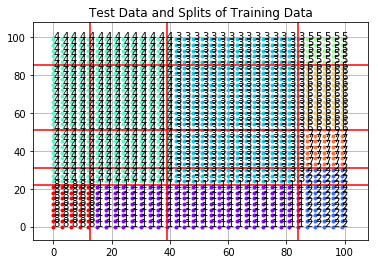

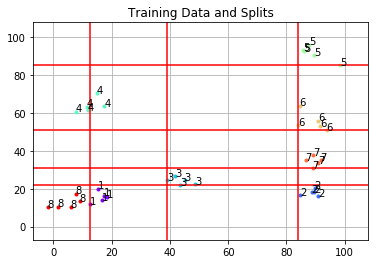

In [20]:
clusters_eval=data_to_clusters(dataset_test_eval)
dt.plots.plotData_tree_split(clusters_eval, x_split, y_split, "Test Data and Splits of Training Data")
dt.plots.plotData_tree_split(clusters, x_split, y_split, "Training Data and Splits")